# Tutorial 3 - Reproducing the results from Vigil-Vásquez, 2022

As our final tutorial, we will use the package to reproduce the results shown in Supplementary
Information of [Vigil-Vásquez, et al. (2022)](https://doi.org/10.3390/ijms23179666), the paper
the proposes the SimSpread formalism and used it to predict drug-target interactions.

Here, we will reproduce the results of the 10-times 10-fold cross-validation for the "Nuclear 
Receptor" dataset obtained from the Supplementary Information of 
[Yamanishi et al. (2008)](https://doi.org/10.1093/bioinformatics/btn162).

First, lets install the necessary packages to run the predictions:

In [1]:
import Pkg; Pkg.add(["NamedArrays", "Distances", "DataFrames", "Chain", "AlgebraOfGraphics", "CairoMakie"])
Pkg.add(url="https://github.com/cvigilv/SimSpread.jl.git", rev = "develop")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
    Updating git-repo `https://github.com/cvigilv/SimSpread.jl.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


# 

In [1]:
using SimSpread

y = read_namedmatrix("data/nr/nr.st_annotation.txt", '\t')'
X₁ = read_namedmatrix("data/nr/nr.sf_maccs.txt", ' '; cols = false)
X₂ = read_namedmatrix("data/nr/nr.sf_fp2.txt", ' '; cols = false)
X₃ = read_namedmatrix("data/nr/nr.sf_ecfp4.txt", ' '; cols = false);

In [4]:
using NamedArrays

setnames!(y, ["D$i" for i in 1:size(y,1)], 1)
setnames!(y, ["T$i" for i in 1:size(y,2)], 2)
setnames!(X₁, ["D$i" for i in 1:size(y,1)], 1)
setnames!(X₂, ["D$i" for i in 1:size(y,1)], 1)
setnames!(X₃, ["D$i" for i in 1:size(y,1)], 1);

In [5]:
println("Number of source nodes (drugs): $(size(y,1))")
println("Number of target nodes (proteins): $(size(y,2))")
println("Number of features in MACCS substructure dictionary: $(size(X₁,2))")
println("Number of features in path-based molecular fingerprint: $(size(X₂,2))")
println("Number of features in circular fingerprint: $(size(X₃,2))")

Number of source nodes (drugs): 54
Number of target nodes (proteins): 26
Number of features in MACCS substructure dictionary: 256
Number of features in path-based molecular fingerprint: 1024
Number of features in circular fingerprint: 4096


## Data splitting

In [6]:
using Random

# Split dataset in 5 groups
splits = split(y, 5; seed = 2)

5-element Vector{Vector{Any}}:
 ["D41", "D16", "D20", "D53", "D35", "D4", "D5", "D37", "D49", "D39"]
 ["D21", "D42", "D24", "D25", "D54", "D6", "D50", "D33", "D52", "D36", "D10"]
 ["D7", "D19", "D2", "D15", "D22", "D13", "D51", "D23", "D11", "D47", "D18"]
 ["D27", "D30", "D1", "D29", "D3", "D12", "D31", "D40", "D38", "D43", "D46"]
 ["D48", "D26", "D44", "D8", "D28", "D17", "D45", "D9", "D14", "D34", "D32"]

As an example, we will develop the pipeline with the first fold and MACCS description:

In [7]:
fold_idx = 1

test_idx = splits[fold_idx]
train_idx = [s for s in names(y,1) if s ∉ test_idx]

ytest = y[test_idx, :]
ytrain = y[train_idx, :]
Xtest = X₁[test_idx, :]
Xtrain = X₁[train_idx, :];

## Meta-description preparation

In [8]:
using Distances, NamedArrays

# Calculate pairwise similarity using features
Dtrain = 1 .- pairwise(Jaccard(), Xtrain.array, dims = 1)
Dtest  = 1 .- pairwise(Jaccard(), Xtest.array, Xtrain.array, dims = 1)

# Convert to NamedArray
Dtrain = NamedArray(Dtrain, (names(Xtrain, 1), names(Xtrain, 1)))
Dtest = NamedArray(Dtest, (names(Xtest, 1), names(Xtrain, 1)))

10×44 Named Matrix{Float64}
A ╲ B │       D1        D2        D3  …       D51       D52       D54
──────┼──────────────────────────────────────────────────────────────
D41   │ 0.384615  0.359375  0.365079  …       0.5   0.40625  0.310345
D16   │ 0.306122  0.297872  0.333333      0.28125  0.254902  0.219512
D20   │ 0.744186  0.714286  0.613636     0.328571  0.666667  0.386364
D53   │     0.45       0.4  0.566038     0.567164      0.45  0.351852
D35   │    0.775       0.7  0.634146     0.308824  0.651163  0.357143
D4    │ 0.837838  0.805556   0.72973      0.30303  0.789474  0.459459
D5    │ 0.680851  0.652174    0.5625     0.366197  0.645833  0.382979
D37   │ 0.690476  0.837838  0.595238     0.328358  0.577778  0.325581
D49   │ 0.191011  0.211765  0.214286     0.393258  0.152174      0.15
D39   │ 0.682927  0.783784  0.666667  …  0.359375  0.642857     0.375

In [9]:
# Generate meta-description from similarity measurements
α = 0.5
Xtrain′ = featurize(Dtrain, α, true)
Xtest′ = featurize(Dtest, α, true)

10×44 Named Matrix{Float64}
A ╲ B │      fD1       fD2       fD3  …      fD51      fD52      fD54
──────┼──────────────────────────────────────────────────────────────
D41   │      0.0       0.0       0.0  …       0.5       0.0       0.0
D16   │      0.0       0.0       0.0          0.0       0.0       0.0
D20   │ 0.744186  0.714286  0.613636          0.0  0.666667       0.0
D53   │      0.0       0.0  0.566038     0.567164       0.0       0.0
D35   │    0.775       0.7  0.634146          0.0  0.651163       0.0
D4    │ 0.837838  0.805556   0.72973          0.0  0.789474       0.0
D5    │ 0.680851  0.652174    0.5625          0.0  0.645833       0.0
D37   │ 0.690476  0.837838  0.595238          0.0  0.577778       0.0
D49   │      0.0       0.0       0.0          0.0       0.0       0.0
D39   │ 0.682927  0.783784  0.666667  …       0.0  0.642857       0.0

In [10]:
# Construct feature-source-target graph for predictions
G = construct(ytrain, ytest, Xtrain′, Xtest′)
display(G)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

## Link prediction with SimSpread

In [11]:
# Predict
ŷ = predict(G, ytest)

10×26 Named Matrix{Float64}
A ╲ B │          T1           T2  …          T25          T26
──────┼──────────────────────────────────────────────────────
D41   │         0.0    0.0645975  …          0.0   0.00202858
D16   │         0.0    0.0372179             0.0          0.0
D20   │   0.0111862     0.171664             0.0    0.0184224
D53   │ 0.000867176     0.109468             0.0   0.00610386
D35   │   0.0117891     0.169768             0.0    0.0183305
D4    │   0.0123931     0.184543             0.0    0.0197337
D5    │  0.00697109     0.159037             0.0    0.0162969
D37   │   0.0115276     0.185973             0.0    0.0171034
D49   │         0.0    0.0311492             0.0          0.0
D39   │    0.010796     0.185425  …          0.0    0.0165791

## Assesing predictive performance

In [12]:
using DataFrames

# Convert predictions matrix into a data frame
preds = DataFrame(fidx = Int64[], s = String[], t = String[], y = Bool[], yhat = Float64[])

for ((s,t), ŷₛₜ) in enamerate(ŷ)
    push!(preds, [fold_idx s t ytest[s,t] ŷₛₜ])
end

first(preds, 5)

Row,fidx,s,t,y,yhat
,Int64,String,String,Bool,Float64
1,1,D41,T1,false,0.0
2,1,D16,T1,false,0.0
3,1,D20,T1,false,0.0111862
4,1,D53,T1,false,0.000867176
5,1,D35,T1,false,0.0117891


In [13]:
using Chain

# Calculate metrics
perf = @chain preds begin
    groupby([:fidx, :s])
    combine(
        [:y, :yhat] => SimSpread.AuROC => "AuROC",
        [:y, :yhat] => SimSpread.AuPRC => "AuPRC",
        [:y, :yhat] => SimSpread.BEDROC => "BEDROC",
        [:y, :yhat] => SimSpread.recallatL => "R@20",
        [:y, :yhat] => SimSpread.precisionatL => "P@20",
        [:y, :yhat] => ((y,yhat) -> SimSpread.maxperformance(collect(y), collect(yhat), SimSpread.f1score)) => "max(F1)",
        [:y, :yhat] => ((y,yhat) -> SimSpread.maxperformance(collect(y), collect(yhat), SimSpread.balancedaccuracy)) => "max(bACC)",
        [:y, :yhat] => ((y,yhat) -> SimSpread.maxperformance(collect(y), collect(yhat), SimSpread.mcc)) => "max(MCC)",
        :yhat => SimSpread.validity_ratio => "Validity ratio"
    )
end

Row,fidx,s,AuROC,AuPRC,BEDROC,R@20,P@20,max(F1),max(bACC),max(MCC),Validity ratio
,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,D41,0.92,0.166667,0.214711,1.0,0.05,0.5,0.96,0.553775,0.461538
2,1,D16,1.0,0.0,1.0,1.0,0.05,1.0,1.0,1.0,0.5
3,1,D20,0.895833,0.113095,0.690119,1.0,0.1,0.666667,0.895833,0.69282,0.807692
4,1,D53,0.979167,0.291667,0.830078,1.0,0.1,0.8,0.979167,0.799305,0.846154
5,1,D35,0.92,0.166667,0.214711,1.0,0.05,0.5,0.96,0.553775,0.807692
6,1,D4,0.76,0.0714286,0.00989837,1.0,0.05,0.25,0.88,0.329502,0.807692
7,1,D5,0.88,0.125,0.0994906,1.0,0.05,0.4,0.94,0.469042,0.807692
8,1,D37,0.96,0.25,0.463369,1.0,0.05,0.666667,0.98,0.69282,0.807692
9,1,D49,0.42,0.0192308,2.08853e-6,1.0,0.05,0.0740741,0.5,-9.92914e-155,0.153846


## Putting it all together

In [14]:
using ProgressMeter

# Initialize accumulator dataframe for predictions
allpreds = DataFrame(iter = Int64[], fp = String[], α = Float64[], fidx = Int64[], s = String[], t = String[], y = Bool[], yhat = Float64[])

# Split dataset in 5 groups
for iter in 1:5
    splits = split(y, 5; seed = 1+iter)
    @showprogress for (fp, X) in zip(["MACCS", "FP2", "ECFP4"], [X₁, X₂, X₃])
        for (fold_idx, test_idx) in enumerate(splits)
            for α in 0.0:0.05:1.0
                # Split dataset in training and testing sets
                train_idx = [s for s in names(y,1) if s ∉ test_idx]

                ytest = y[test_idx, :]
                ytrain = y[train_idx, :]
                Xtest = X[test_idx, :]
                Xtrain = X[train_idx, :]

                # Calculate meta-description
                Dtrain = 1 .- pairwise(Jaccard(), Xtrain.array, dims = 1)
                Dtest  = 1 .- pairwise(Jaccard(), Xtest.array, Xtrain.array, dims = 1)

                Dtrain = NamedArray(Dtrain, (names(Xtrain, 1), names(Xtrain, 1)))
                Dtest = NamedArray(Dtest, (names(Xtest, 1), names(Xtrain, 1)))

                Xtrain′, Xtest′ = map(D -> featurize(D, α, true), [Dtrain, Dtest])

                # Construct feature-source-target graph for predictions
                G = construct(ytrain, ytest, Xtrain′, Xtest′)

                # Predict drug-target interactions of testing set
                ŷ = predict(G, ytest)
                clean!(ŷ, first(G), ytest)

                # Convert predictions matrix into a data frame
                for ((s,t), ŷₛₜ) in enamerate(ŷ)
                    push!(allpreds, [iter fp α fold_idx s t ytest[s,t] ŷₛₜ])
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [37]:
# Evaluate predictions
allperf = @chain allpreds begin
    filter(:yhat => s -> s ≠ -99, _)
    groupby([:iter, :fp, :α, :fidx, :s])
    combine(
        [:y, :yhat] => SimSpread.AuROC => "AuROC",
        [:y, :yhat] => SimSpread.AuPRC => "AuPRC",
        [:y, :yhat] => SimSpread.BEDROC => "BEDROC",
        [:y, :yhat] => ((y,yhat) -> SimSpread.recallatL(collect(y), collect(yhat), 5)) => "R@5",
        [:y, :yhat] => ((y,yhat) -> SimSpread.precisionatL(collect(y), collect(yhat), 5)) => "P@5",
        [:y, :yhat] => ((y,yhat) -> SimSpread.maxperformance(collect(y), collect(yhat), SimSpread.f1score)) => "max(F1)",
        [:y, :yhat] => ((y,yhat) -> SimSpread.maxperformance(collect(y), collect(yhat), SimSpread.balancedaccuracy)) => "max(bACC)",
        [:y, :yhat] => ((y,yhat) -> SimSpread.maxperformance(collect(y), collect(yhat), SimSpread.mcc)) => "max(MCC)",
        :yhat => SimSpread.validity_ratio => "Validity ratio"
    )
    sort(Symbol("Validity ratio"), rev = true)
    stack(
        Between(:AuROC, Symbol("Validity ratio")), 
        [:iter, :fp, :α, :fidx], 
        variable_name = "metric",
        value_name = "performance"
    )
    filter(row -> all(x -> !(x isa Number && isnan(x)), row), _)
end;

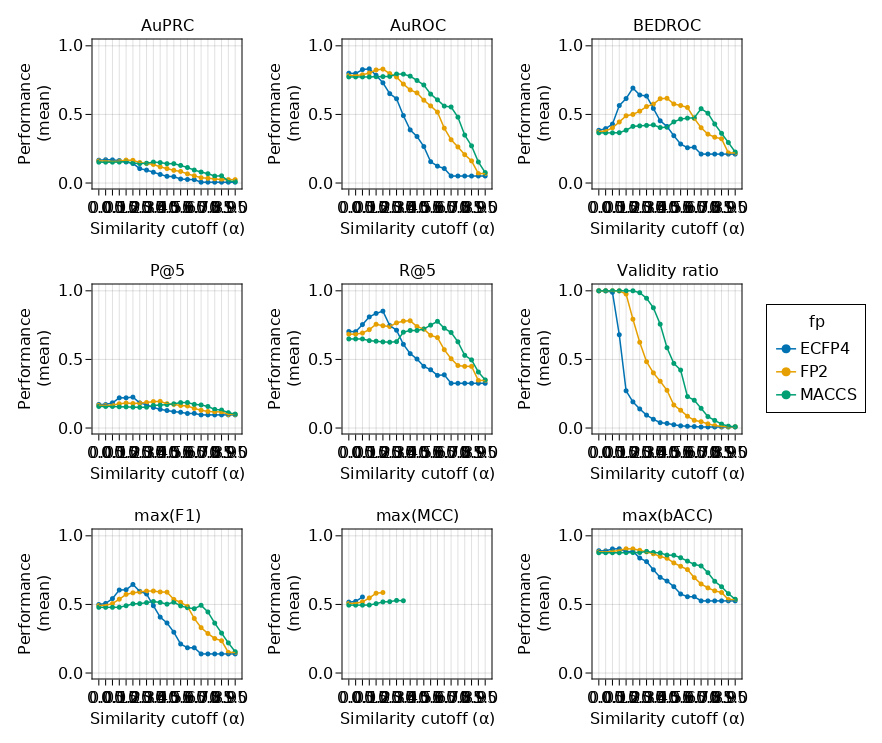

In [40]:
using AlgebraOfGraphics, CairoMakie

# Evaluate predictions
plt = data(allperf)
plt *= expectation() * (visual(Scatter; markersize = 5) + visual(Lines))
plt *= mapping(
    :α => nonnumeric => "Similarity cutoff (α)",   
    :performance => "Performance\n(mean)"
)
plt *= mapping(layout = :metric, color = :fp)

draw(plt; axis = (width = 150, height = 150))